<a href="https://colab.research.google.com/github/BillWENZE/BillWENZE/blob/main/SVM_Hands_On.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine for Trading

**Background:**

Suppose you are working as an analyst at an investment bank. Your manager asked you to implement a new trading algorithm for NVDA.

You decided to use the following indicators:

* Average True Range
* Commodity Channel Index
* Relative Strength Index
* Bollinger Bands
* On Balance Volume
* Momentum
* MACD


Your training set includes data up to 04/30/2023. You will apply time series cross-validation to tune the hyper-parameter. Test the model on the last 30 trading days.

**Objective**
* Use SVM Classification on financial data
* Use Randomized Search
* Use Time Series Cross Validation
* Evaluate trading model

In [ ]:
! pip install ta-lib # Will not work in COLAB, but will work in personal

This will work for COLAB

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4063    0  4063    0     0  15513      0 --:--:-- --:--:-- --:--:-- 15567
100  517k  100  517k    0     0   947k      0 --:--:-- --:--:-- --:--:-- 6195k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4075    0  4075    0     0  15075      0 --:--:-- --:--:-- --:--:-- 15092
100  392k  100  392k    0     0   758k      0 --:--:-- --:--:-- --:--:--  758k


In [ ]:
! pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import yfinance as yf
import talib as ta
from talib import MA_Type
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit as tscv

In [ ]:
msft=yf.Ticker('nvda')
df=msft.history('max')

In [ ]:
df.tail(30)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-22 00:00:00-04:00,911.409973,947.780029,908.340027,942.890015,58521500,0.0,0.0
2024-03-25 00:00:00-04:00,939.409973,967.659973,935.099976,950.020020,55213600,0.0,0.0
2024-03-26 00:00:00-04:00,958.510010,963.750000,925.020020,925.609985,51364800,0.0,0.0
2024-03-27 00:00:00-04:00,931.119995,932.400024,891.229980,902.500000,58606700,0.0,0.0
2024-03-28 00:00:00-04:00,900.000000,913.000000,891.929993,903.559998,43521200,0.0,0.0
2024-04-01 00:00:00-04:00,902.989990,922.250000,892.039978,903.630005,45244100,0.0,0.0
2024-04-02 00:00:00-04:00,884.479980,900.940002,876.200012,894.520020,43306400,0.0,0.0
2024-04-03 00:00:00-04:00,884.840027,903.739990,884.000000,889.640015,37006700,0.0,0.0
2024-04-04 00:00:00-04:00,904.059998,906.340027,858.799988,859.049988,43496500,0.0,0.0


In [ ]:
help(ta.CCI)

Help on function CCI in module talib._ta_lib:

CCI(...)
    CCI(high, low, close[, timeperiod=?])
    
    Commodity Channel Index (Momentum Indicators)
    
    Inputs:
        prices: ['high', 'low', 'close']
    Parameters:
        timeperiod: 14
    Outputs:
        real



In [ ]:
df['High Shifted']=df['High'].shift(1)
df['Low Shifted'] = df['Low'].shift(1)
df['Close Shifted'] = df['Close'].shift(1)
df['Upper BBand'], df['Middle BBand'],df['Lower BBand']= ta.BBANDS(df['Close Shifted'],timeperiod=20)
df['RSI'] = ta.RSI(np.array(df['Close Shifted']), timeperiod=14)
df['Macd'], df['Macd Signal'],df['Macd Hist'] = ta.MACD(df['Close Shifted'], fastperiod=12, slowperiod=26, signalperiod=9)
df['Momentum'] = ta.MOM(df['Close Shifted'],timeperiod=12)
df['OBV'] = ta.OBV(df['Close Shifted'],df['Volume'].shift(1))
df['ATR'] = ta.ATR(df['High'].shift(1),df['Low'].shift(1),df['Close'].shift(1))
df['Returns'] = np.log(df['Close']/df['Close'].shift(1))
df['CCI']=ta.CCI(df['High Shifted'],df['Low Shifted'],df['Close Shifted'])

condlist=[df.Returns >= df['Returns'].iloc[:-30].mean()+df['Returns'].iloc[:-30].std(), df.Returns < df['Returns'].iloc[:-30].mean()+df['Returns'].iloc[:-30].std()]
choicelist=[1,-1]
df['Signal'] =np.select(condlist,choicelist,0)


df.dropna(inplace=True)

X=df.drop(['Signal','Returns','Open','Close','Volume','High','Low','Dividends','Stock Splits'],axis=1)
Y=df['Signal']


In [ ]:
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()

In [ ]:
X_train =minmax.fit_transform(X.iloc[:-30,:])
X_test = pd.DataFrame(minmax.transform(X)).iloc[-30:,:]
y_train = Y.iloc[:-30]
y_test = Y.iloc[-30:]

In [ ]:
# Takes approx 6 mins
# Call the classifier:
clf = SVC(kernel='rbf')
# Parameter Grid
param_grid={'C':[0.01,0.1,1,5,10]}
# Randomized Search over Space and Fit:
clf_search = RandomizedSearchCV(clf, param_distributions=param_grid, cv = tscv(2,test_size=30, gap=0))
clf_search.fit(X_train,y_train)
# Predict
y_pred=clf_search.predict(X_test)

In [ ]:
from sklearn import metrics
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)

In [ ]:
print(Accuracy)
print(Precision)
print(Recall)

0.9
0.0
0.0


In [ ]:
df['SVM Signal'] = 0
df['SVM Returns'] = 0
df['Total Strat Returns'] = 0
df['Market Returns'] = 0

In [ ]:
Signal_Column = df.columns.get_loc('SVM Signal')
Strat_Column = df.columns.get_loc('SVM Returns')
Return_Column = df.columns.get_loc('Total Strat Returns')
Market_Column = df.columns.get_loc('Market Returns')

df.iloc[-30:,Signal_Column] = list(map(int,y_pred))
df['SVM Returns'] = df['SVM Signal'] * df['Returns'].shift(-1)

df.iloc[-30:,Return_Column] = np.nancumprod(1+df['SVM Returns'][-30:])
df.iloc[-30:,Market_Column] = np.nancumprod(1+df['Returns'][-30:])

df['Sharpe_Ratio'] = (np.mean(df['Total Strat Returns'][-30:]))/np.nanstd(df['Total Strat Returns'][-30:])

In [ ]:
print(Accuracy*100)

90.0


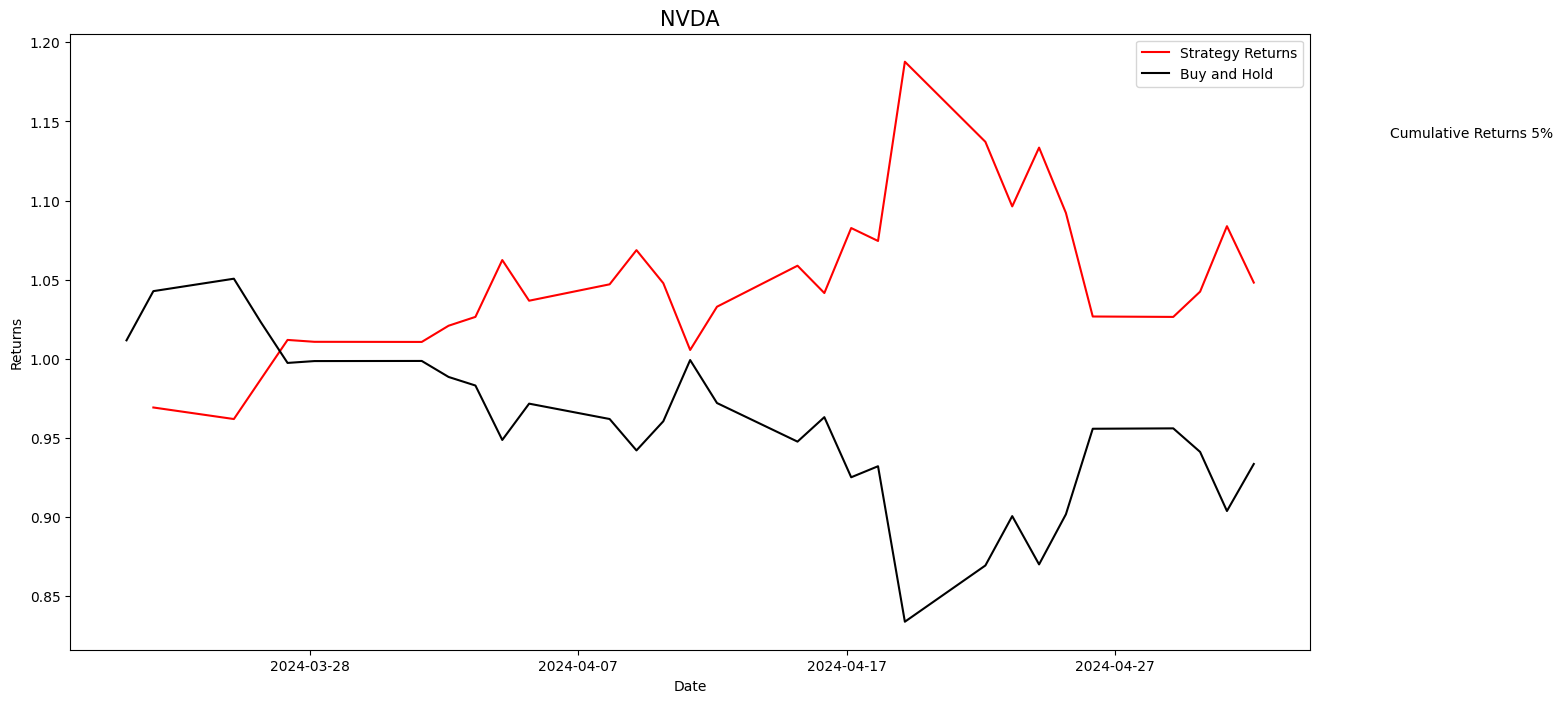

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16, 8
                                ))

ax.plot(df[-30:].index.values, (df['Total Strat Returns'][-30:]).shift(), color='r', label="Strategy Returns")
ax.plot(df[-30:].index.values, (df['Market Returns'][-30:]), color='k', label="Buy and Hold")

ax.set(xlabel= "Date",ylabel="Returns")
plt.title('NVDA',fontsize=15)
ax.xaxis.set_major_locator(ticker.AutoLocator())

plt.figtext(.95,0.75, s="Cumulative Returns "+'5%')
# plt.figtext(.95,0.72,s="Model Accuracy " +'0.43')
# plt.figtext(.95,0.69,s="Model Precision " +'0.43')
# plt.figtext(.95,0.66,s="Model Recall " +'1')

plt.legend(loc='best')
plt.show()

In [ ]:
df[['Total Strat Returns','Market Returns','Sharpe_Ratio']].tail(30)

,Total Strat Returns,Market Returns,Sharpe_Ratio
Date,,,
2024-03-21 00:00:00-04:00,0.969264,1.011694,21.92907
2024-03-22 00:00:00-04:00,0.961962,1.042790,21.92907
2024-03-25 00:00:00-04:00,0.987002,1.050645,21.92907
2024-03-26 00:00:00-04:00,1.011957,1.023297,21.92907
2024-03-27 00:00:00-04:00,1.010770,0.997424,21.92907
2024-03-28 00:00:00-04:00,1.010691,0.998594,21.92907
2024-04-01 00:00:00-04:00,1.020932,0.998672,21.92907
2024-04-02 00:00:00-04:00,1.026517,0.988552,21.92907
2024-04-03 00:00:00-04:00,1.062435,0.983145,21.92907
